In [2]:
import json
import numpy as np
import os
import math
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm
from skimage.transform import resize
from matplotlib import pyplot as plt
from tensorflow.python.keras import models, layers, losses, optimizers, preprocessing, utils

%matplotlib notebook

In [3]:
LABEL_COUNT = 228
IMAGE_SIZE = ( 80, 80, 3 )

In [4]:
train_json = None
with open( 'data/train.json' ) as file:
    train_json = json.load( file )

In [ ]:
model = models.Sequential()

model.add( 
    layers.Conv2D( 
        filters=64, 
        kernel_size=( 5, 5 ),
        input_shape=IMAGE_SIZE,
        padding='same',
        activation='relu'
    )
)

model.add(
    layers.MaxPooling2D(
        pool_size=( 2, 2 ),
        padding='same'
    )
)

model.add( 
    layers.Conv2D( 
        filters=64, 
        kernel_size=( 5, 5 ),
        padding='same',
        activation='relu'
    )
)

model.add(
    layers.MaxPooling2D(
        pool_size=( 2, 2 ),
        padding='same'
    )
)

model.add(
    layers.Flatten()
)

model.add(
    layers.Dense(
        1024,
        activation='relu'
    )
)

model.add( 
    layers.Dropout( 0.3 )
)

model.add(
    layers.Dense( LABEL_COUNT, activation='softmax' )
)

loss = losses.binary_crossentropy
optimizer = optimizers.SGD()

model.compile( optimizer, loss )

In [5]:
image_basepath = 'data/images/'
images = os.listdir( image_basepath )
images = np.array( images )
images

array(['1.jpg', '10.jpg', '100.jpg', ..., '999997.jpg', '999998.jpg',
       '999999.jpg'], dtype='<U11')

In [6]:
def loadImage( path ):
    image = plt.imread( path )
    image = resize( image, IMAGE_SIZE )

    image_id = os.path.splitext( os.path.basename( path ) )[ 0 ]
    annotation = train_json[ 'annotations' ][ int( image_id ) - 1 ]

    encoded_labels = np.full( ( LABEL_COUNT ), 0 )
    labels = annotation[ 'labelId' ]

    for label in labels:
        label = int( label ) - 1
        if label < 0:
            raise 'wtf'
        encoded_labels[ label ] = 1

    return [ image, encoded_labels ]

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

C:\Users\mike\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<IPython.core.display.Javascript object>


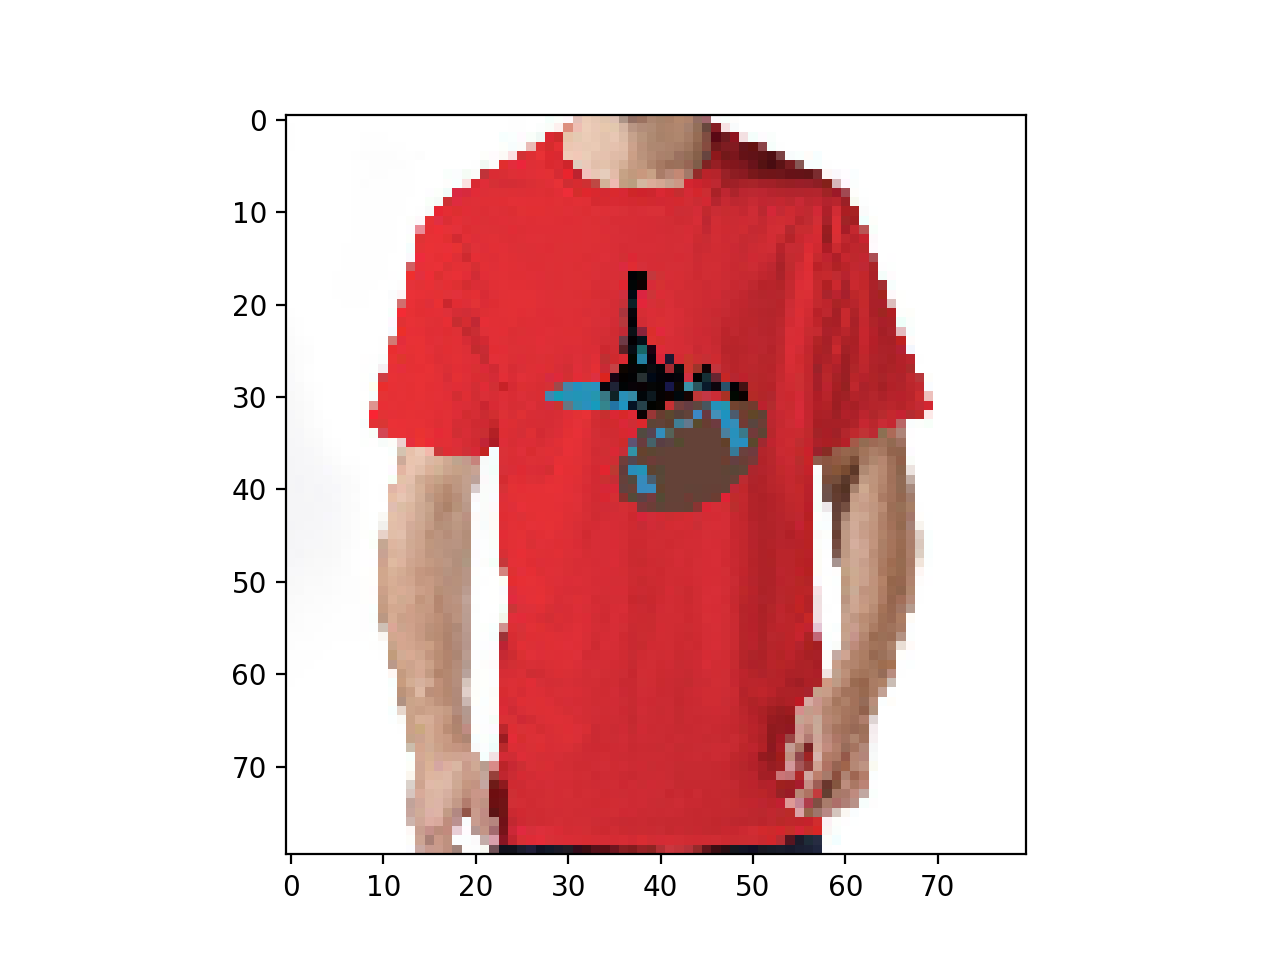

In [10]:
def getBatch( batch_size=10000 ):
    batch_images = images[ np.random.choice( images.shape[ 0 ], batch_size, replace=False ) ]
    loaded_batch_images = np.zeros( ( batch_size, 80, 80, 3 ) )
    batch_labels = np.zeros( ( batch_size, LABEL_COUNT ) )
    with tqdm( total=batch_size ) as pbar:
        for i, batch_image in enumerate( batch_images ):
            full_path_image = os.path.join( image_basepath, batch_image )
            loaded_image, labels = loadImage( full_path_image )
            loaded_batch_images[ i, : ] = loaded_image
            batch_labels[ i, : ] = labels
            pbar.update( 1 )
    return loaded_batch_images, batch_labels

test_batch = getBatch( 1 )

plt.imshow( test_batch[ 0 ][ 0 ] )

In [ ]:
x, y = getBatch( 30000 )

HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

C:\Users\mike\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\mike\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [13]:
y[ y < 0 ] = 0
print( y )

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(30000, 80, 80, 3)


In [ ]:
model.fit(
    x, y, 
    epochs=4,
    validation_split=0.1,
    verbose=1
)

In [ ]:
loaded_test_image, actual_labels = loadImage( 'data/images/5123.jpg' )
test_image = np.zeros( ( 1, 40, 40, 3 ) )
test_image[ 0, : ] = loaded_test_image

test_output = model.predict( test_image, verbose=1 )

In [ ]:
print( test_output )
plt.bar( range( LABEL_COUNT ), test_output[ 0 ] )
print( np.argwhere( test_output > 0.025 )[ :, 1 ] )
print( np.argwhere( actual_labels > 0 )[ :, 0 ] )